# In this notebook, we compare the out of fold predictions of the models with the best parameters

In [ ]:
!pip install numpy_ext
!pip install openpyxl

In [1]:
import boto3
import pandas as pd
import glob

import io
import os

from datetime import datetime, date, timedelta

import itertools
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from s3 import write_to_s3, read_from_s3, list_s3_contents
from helper import *

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection._split import _BaseKFold
from lightgbm import LGBMClassifier

from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,\
                              GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import cross_val_predict

In [ ]:
YEARS = 3
START_DATE, END_DATE = get_start_end_dates(YEARS)

In [ ]:
dates = pd.bdate_range(START_DATE, END_DATE)
dates

In [ ]:
TRAIN_PROPORTION = .8
TRAIN_END_DATE = END_DATE - timedelta(days=365 * YEARS * TRAIN_PROPORTION)
TEST_START_DATE = TRAIN_END_DATE 

In [2]:
training_test_df_monthly = read_from_s3("train_test/train_test_21_days.csv")
training_test_df_monthly.date = pd.to_datetime(training_test_df_monthly.date)

In [3]:
training_df = training_test_df_monthly[(training_test_df_monthly.date < str(TRAIN_END_DATE))].reset_index(drop=True).copy()
test_df = training_test_df_monthly[(training_test_df_monthly.date >= str(TEST_START_DATE))].reset_index(drop=True).copy()

In [4]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [5]:
x_vals = [c for c in training_df.columns if c not in ["date", "ticker", "target", "model_number", "Unnamed: 0", "alpha083", "alpha084"]]

In [6]:
training_df.reset_index(drop=True, inplace=True)

In [ ]:
train_dates = pd.bdate_range(START_DATE, TRAIN_END_DATE + timedelta(1))

In [ ]:
folds = np.array_split(train_dates, 5)

In [7]:
fold_1 = training_df[(training_df.date <= folds[0][-1])].index.values
fold_2 = training_df[(training_df.date >= folds[1][0]) & (training_df.date <= folds[1][-1])].index.values
fold_3 = training_df[(training_df.date >= folds[1][0]) & (training_df.date <= folds[1][-1])].index.values
fold_4 = training_df[(training_df.date >= folds[1][0]) & (training_df.date <= folds[1][-1])].index.values
fold_5 = training_df[(training_df.date >= folds[1][0]) & (training_df.date <= folds[1][-1])].index.values

In [8]:
cv_folds = [(np.concatenate([fold_2, fold_3, fold_4, fold_5]), fold_1),
(np.concatenate([fold_1, fold_3, fold_4, fold_5]), fold_2),
(np.concatenate([fold_1, fold_2, fold_4, fold_5]), fold_3),
(np.concatenate([fold_1, fold_2, fold_3, fold_5]), fold_4),
(np.concatenate([fold_1, fold_2, fold_3, fold_4]), fold_5)]

In [11]:
X_train = training_df.copy()
y_train = X_train.target.copy()
X_train = X_train.drop(columns="target")
X_train[x_vals] = X_train[x_vals].astype(float)

X_test = test_df.copy()
y_test = X_test.target.copy()
X_test = X_test.drop(columns="target")
X_test[x_vals] = X_test[x_vals].astype(float)

# Best Parameters

In [13]:
estimator = {
        'RandomForestClassifier': RandomForestClassifier(criterion="entropy", max_depth=None,n_estimator=100, max_features=None, min_samples_leaf=3, min_samples_split=2),
        'ExtraTreesClassifier': ExtraTreesClassifier(max_features=None, n_estimators=100,max_depth=None, min_samples_split=2, criterion='entropy', min_samples_leaf=3),
        'AdaBoostClassifier': AdaBoostClassifier(base_estimator = DecisionTreeClassifier(criterion="entropy",
                                                                                         max_depth=30,
                                                                                         max_features=None,
                                                                                         min_samples_leaf=3,
                                                                                         min_samples_split=10),
                                                 n_estimators = 10),
        'GradientBoostingClassifier': GradientBoostingClassifier(learning_rate=0.1, max_depth=None, max_features=None,
                                                                min_samples_leaf=10, min_samples_split=2,n_estimators=10,subsample=1),
        'LGBMClassifier': LGBMClassifier(colsample_bytree=0.75, max_depth=-1,subsample=1)
        }

In [18]:
x_vals = [x for x in x_vals if x not in ["alpha054"]]

Obtain predictions for each of the out of fold. Train on fold 4, test on the last fold.

In [ ]:
monthly_all_predictions = {}
monthly_all_accuracy = {}
monthly_all_f1_scores = {}
for est_name in ['LGBMClassifier', 'AdaBoostClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier']:
    print(est_name)
    current_estimator = estimator[est_name]
    monthly_all_predictions[est_name] = []
    monthly_all_accuracy[est_name] = []
    monthly_all_f1_scores[est_name] = []
    for i in tqdm(range(5)):
        in_fold_index, out_fold_index = cv_folds[i]
        X_in_fold, y_in_fold = X_train.iloc[in_fold_index][x_vals], y_train.iloc[in_fold_index]
        X_out_of_fold, y_out_of_fold = X_train.iloc[out_fold_index][x_vals], y_train.iloc[out_fold_index]
        current_estimator.fit(X_in_fold, y_in_fold)
        
        y_pred = current_estimator.predict(X_out_of_fold)
        accuracy = accuracy_score(y_true=y_out_of_fold, y_pred=y_pred)
        f1 = f1_score(y_true=y_out_of_fold, y_pred=y_pred, average="macro")
        
        monthly_all_predictions[est_name].append(y_pred)
        monthly_all_accuracy[est_name].append(accuracy)
        monthly_all_f1_scores[est_name].append(f1)

In [20]:
accuracy_df = pd.DataFrame(monthly_all_accuracy, index=["(Acc) Fold " + str(i) for i in range(1, 6)])
f1_df = pd.DataFrame(monthly_all_f1_scores, index=["(F1) Fold " + str(i) for i in range(1, 6)])

In [21]:
write_to_s3(pd.concat([accuracy_df, f1_df]), "results/cross_val_scores_f1_acc_monthly.csv")
write_to_s3(accuracy_df, "results/cross_val_scores_acc_monthly.csv")
write_to_s3(f1_df, "results/cross_val_scores_f1_monthly.csv")

Text(0.5, 1.0, 'Accuracy Scores Heatmap (Monthly)')

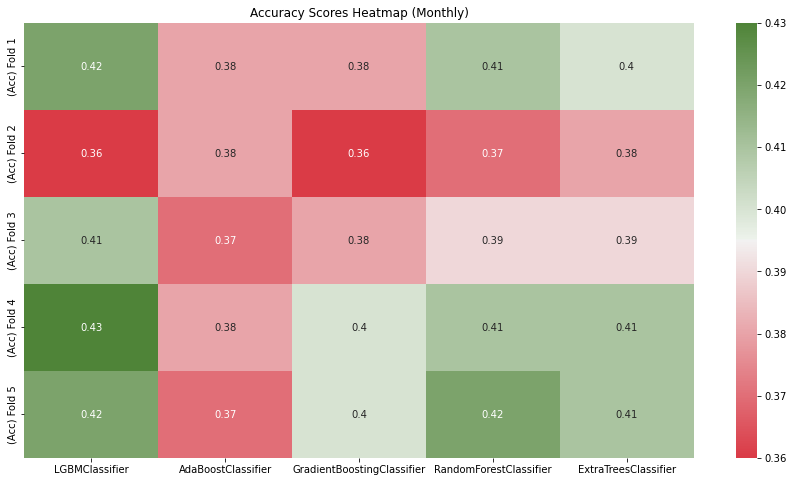

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,8))
heatmap_df = round(accuracy_df, 2)
sns.heatmap(heatmap_df, annot=True, cmap=sns.diverging_palette(10, 120, as_cmap=True))
plt.xticks(rotation=0)
plt.title("Accuracy Scores Heatmap (Monthly)")

Text(0.5, 1.0, 'F1 Scores Heatmap (Monthly)')

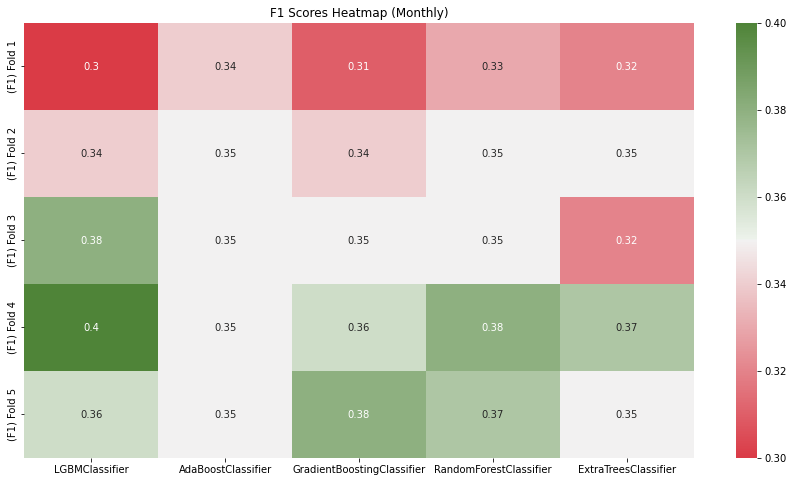

In [24]:
import seaborn as sns
plt.figure(figsize=(15,8))
heatmap_df = round(f1_df, 2)
sns.heatmap(heatmap_df, annot=True, cmap=sns.diverging_palette(10, 120, as_cmap=True))
plt.xticks(rotation=0)
plt.title("F1 Scores Heatmap (Monthly)")

[Text(0, 0, '0.356'),
 Text(0, 0, '0.355'),
 Text(0, 0, '0.348'),
 Text(0, 0, '0.346'),
 Text(0, 0, '0.341')]

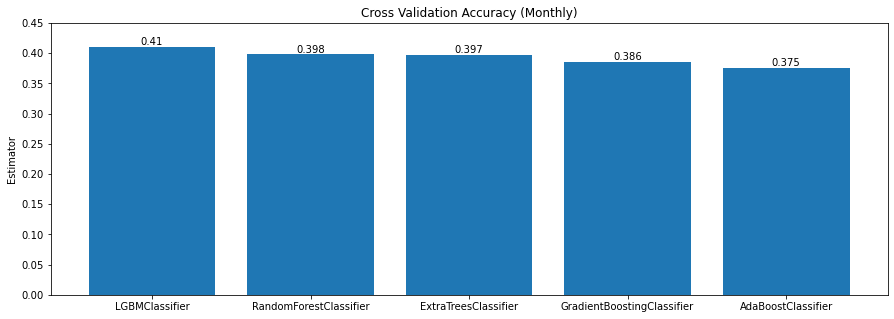

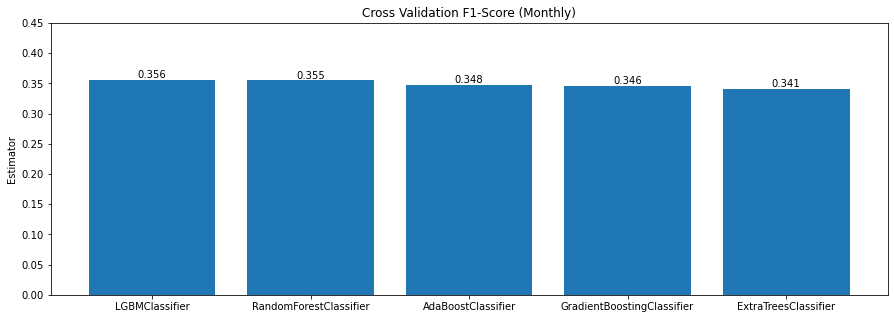

In [25]:
accuracy = accuracy_df.mean().sort_values(ascending=False).round(3)

fig, ax = plt.subplots(figsize=(15,5))
bar_container = ax.bar(accuracy.index, accuracy.values)
ax.set(ylabel='Estimator', title='Cross Validation Accuracy (Monthly)', ylim=(0, 0.45))
ax.bar_label(bar_container, labels=accuracy.values, fmt='{:,.0f}')

f1_plot = f1_df.mean().sort_values(ascending=False).round(3)
fig, ax = plt.subplots(figsize=(15,5))
bar_container = ax.bar(f1_plot.index, f1_plot.values)
ax.set(ylabel='Estimator', title='Cross Validation F1-Score (Monthly)', ylim=(0, 0.45))
ax.bar_label(bar_container, labels=f1_plot.values, fmt='{:,.0f}')

In [26]:
final_prediction_dataframe_monthly = {}
for est_name in monthly_all_predictions.keys():
    final_prediction_dataframe_monthly[est_name] = np.concatenate(monthly_all_predictions[est_name])
final_prediction_dataframe_monthly = pd.DataFrame(final_prediction_dataframe_monthly, index=np.concatenate([fold_1,fold_2,fold_3,fold_4,fold_5]))

In [27]:
write_to_s3(final_prediction_dataframe_monthly, "results/final_prediction_dataframe_monthly.csv")

Text(0.5, 1.0, 'Prediction Correlation (Monthly)')

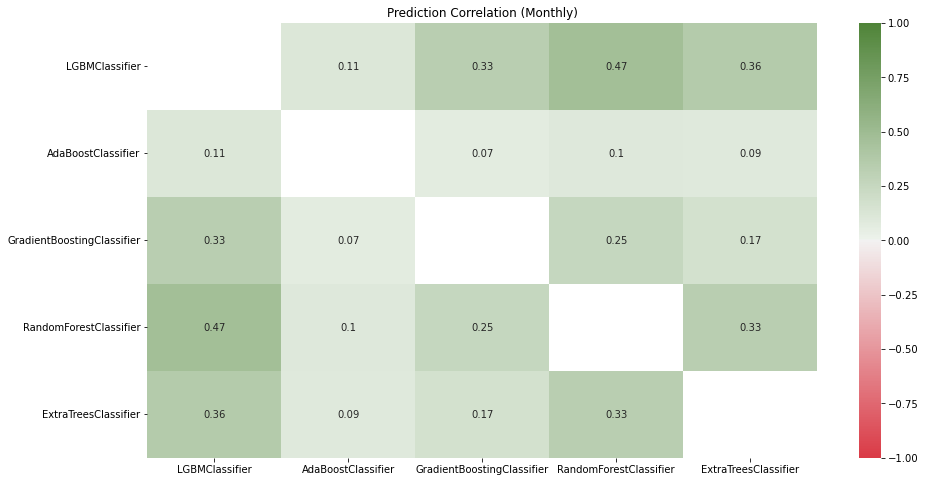

In [28]:
import seaborn as sns
plt.figure(figsize=(15,8))
heatmap_df = round(final_prediction_dataframe_monthly.corr(), 2)
for i in range(len(heatmap_df)):
    heatmap_df.iloc[i,i] = np.nan
sns.heatmap(heatmap_df, annot=True, cmap=sns.diverging_palette(10, 120, as_cmap=True), vmin=-1, vmax=1)
plt.xticks(rotation=0)
plt.title("Prediction Correlation (Monthly)")

In [38]:
training_df_preds = training_df.merge(final_prediction_dataframe_monthly, left_index=True, right_index=True, how="left")

In [43]:
in_sample_dates = pd.DataFrame(pd.bdate_range(training_df_preds.date.min(), training_df_preds.date.max())).rename(columns={0:"date"})

# Get Returns 

In [ ]:
price_df_yf = get_price_data_yf(dates)

price_df_investingdotcom = get_price_investingdotcom_data()

backtest_dates = pd.DataFrame(pd.bdate_range(START_DATE, END_DATE)).rename(columns={0:"Date"})
price_df_yf = backtest_dates.merge(price_df_yf, on ="Date")
price_df_investingdotcom = backtest_dates.merge(price_df_investingdotcom, on ="Date")
price_df_investingdotcom = price_df_investingdotcom.set_index("Date")
price_df_investingdotcom = price_df_investingdotcom[price_df_investingdotcom.columns[~price_df_investingdotcom.columns.isin(price_df_yf)]]
price_df_investingdotcom.reset_index(inplace=True)
price_df = price_df_investingdotcom.merge(price_df_yf, on="Date")
price_df = price_df.set_index("Date")

returns_df = price_df.pct_change().copy()

Take care of severe outliers (data wrong)

In [158]:
remove_rtns = (returns_df > 0.4).sum()[(returns_df > 0.4).sum() > 10].index

In [160]:
returns_df = returns_df[[c for c in returns_df.columns if c not in remove_rtns]]

In [171]:
returns_df = returns_df.clip(upper=0.3, lower=-0.3)

In [178]:
mask = read_from_s3("historical_sp500_mask_2010_onwards.csv").rename(columns={"Unnamed: 0":"date"})
mask.date = pd.to_datetime(mask.date)
mask.set_index("date", inplace=True)
mask = in_sample_dates.merge(mask, on="date", how="left").set_index("date")
mask = mask[set(mask.columns).intersection(set(returns_df.columns))]

In [ ]:
training_df_preds = training_df_preds.drop_duplicates(subset=["date", "ticker"])

In [183]:
model_returns = dict()
for model_name in ["LGBMClassifier", "AdaBoostClassifier", "GradientBoostingClassifier", "RandomForestClassifier", "ExtraTreesClassifier"]:
    position_long_only_signal = in_sample_dates.merge(training_df_preds.pivot(index="date", columns="ticker", values=model_name).reset_index(), on="date", how="left")
    # Maximum holding period of 21 days, ffill
    position_long_only_signal = position_long_only_signal.ffill(limit=21).set_index("date").clip(lower=0).fillna(0)
    # Mask for point in timeness
    position_long_only_signal = position_long_only_signal * mask
    # Equal weight portfolio. If there are 10 stocks, assign 1/10 weight
    # Where we have returns (recall we excluded some returns due to error)
    position_long_only_weight = position_long_only_signal.div(position_long_only_signal.sum(axis=1), axis=0).fillna(0)
    common_columns = position_long_only_weight.columns[position_long_only_weight.columns.isin(returns_df.columns)]
    # Final Portfolio
    position_long_only_weight = position_long_only_weight[common_columns]
    port_returns = returns_df.copy().reset_index().rename(columns={"Date":"date"})
    port_returns = in_sample_dates.merge(port_returns, on="date", how="left").set_index("date").fillna(0)[position_long_only_weight.columns]
    portfolio_long_only = (port_returns[position_long_only_weight.columns] * position_long_only_weight.fillna(0))
    
    model_returns[model_name] = portfolio_long_only.sum(axis=1)

In [331]:
import yfinance as yf

price_dataframe = yf.download("^GSPC")

[*********************100%***********************]  1 of 1 completed


Text(0.5, 1.0, 'Returns Correlation (Monthly)')

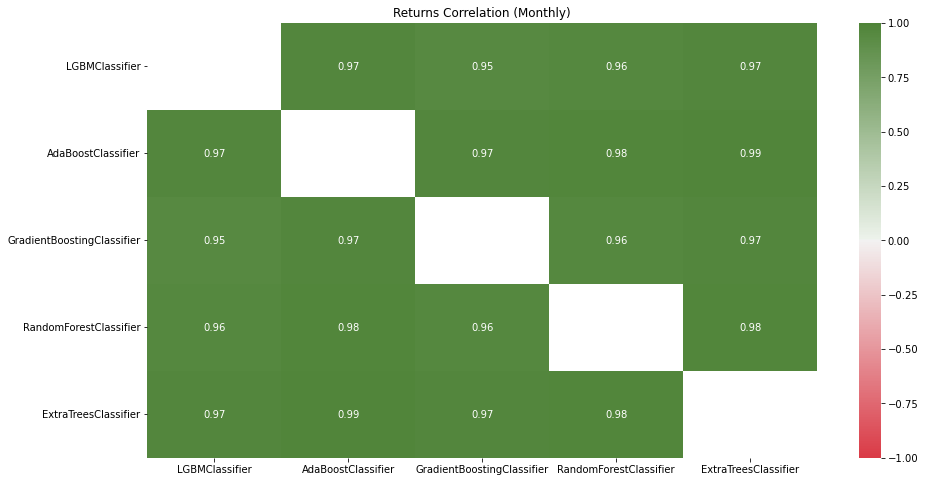

In [269]:
plt.figure(figsize=(15,8))
heatmap_df = round(pd.DataFrame(model_returns).corr(), 2)
for i in range(len(heatmap_df)):
    heatmap_df.iloc[i,i] = np.nan
sns.heatmap(heatmap_df, annot=True, cmap=sns.diverging_palette(10, 120, as_cmap=True), vmin=-1, vmax=1)
plt.xticks(rotation=0)
plt.title("Returns Correlation (Monthly)")

Text(0, 0.5, 'Cumulative Log Returns (%)')

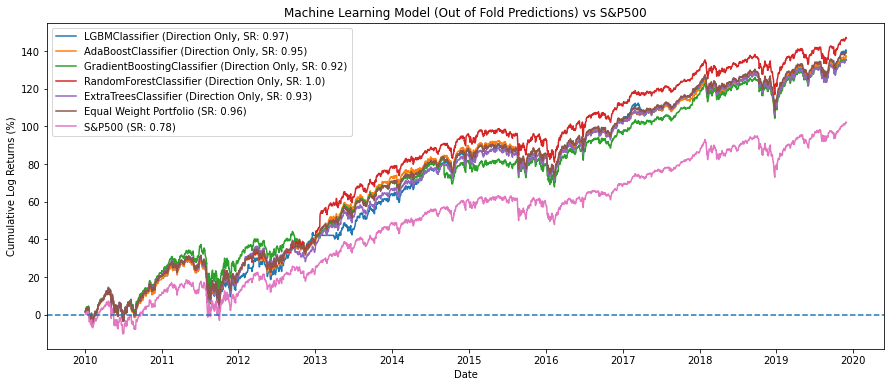

In [333]:
price_dataframe = in_sample_dates.merge(price_dataframe.reset_index().rename(columns={"Date":"date"})).set_index("date")

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for model_name in model_returns.keys():
    # For each model, plot returns
    curr_ml_model = model_returns[model_name]
    lo_sr = round((curr_ml_model.mean() / curr_ml_model.std() * 260**0.5), 2)
    sp_500_sr = round(((price_dataframe[["Adj Close"]].pct_change()).mean() / (price_dataframe[["Adj Close"]].pct_change()).std() * 260 **0.5), 2)
    sp_500_sr = sp_500_sr.values[0]
    plt.plot(np.log(curr_ml_model+1).cumsum()*100, label=f"{model_name} (Direction Only, SR: {lo_sr})")
    
ew_portfolio = pd.DataFrame(model_returns).mean(axis=1)
ew_sr = round((ew_portfolio.mean() / ew_portfolio.std() * 260**0.5), 2)
ew_portfolio = np.log(ew_portfolio+1).cumsum()*100

plt.plot(ew_portfolio, label=F"Equal Weight Portfolio (SR: {ew_sr})")

plt.plot(np.log(price_dataframe[["Adj Close"]].pct_change()+1).cumsum()*100, label=F"S&P500 (SR: {sp_500_sr})")
plt.axhline(0, ls="--")
plt.legend()
plt.title("Machine Learning Model (Out of Fold Predictions) vs S&P500")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Returns (%)")

# Train and store 2 best models; LGBM and RandomForest
# We picked LGBM as the best model in the end; 41% accuracy on test set

In [206]:
direction_model = LGBMClassifier(colsample_bytree=0.75, max_depth=-1,subsample=1)
direction_model.fit(X_train[x_vals], y_train)

LGBMClassifier(colsample_bytree=0.75, subsample=1)

In [208]:
direction_model_RF = RandomForestClassifier()
direction_model_RF.fit(X_train[x_vals], y_train)

RandomForestClassifier()

In [221]:
pickle_dump_to_s3(direction_model_RF, 'model/RandomForest.sav')

In [222]:
pickle_dump_to_s3(direction_model, 'model/LGBM.sav')

In [223]:
import time
import numpy as np

start_time = time.time()
importances = direction_model_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in direction_model_RF.estimators_], axis=0)
elapsed_time = time.time() - start_time

# LGBM Metrics

In [211]:
train_preds = direction_model.predict(X_train[x_vals])

In [218]:
preds_test = direction_model.predict(X_test[x_vals])

Confusion matrix, without normalization
[[180621  32231 131431]
 [ 53983  82739 140744]
 [ 70591  36663 337612]]


Text(0.5, 1.0, 'Confusion Matrix (Train LGBM)')

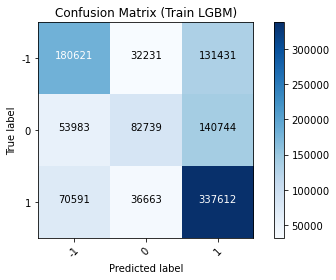

In [237]:
import seaborn as sns

cm = confusion_matrix(y_train, train_preds)
plot_confusion_matrix(cm, [-1, 0, 1])
plt.title("Confusion Matrix (Train LGBM)")

In [238]:
from sklearn.metrics import classification_report
print("Classification Report for Train")
print(classification_report(y_train, train_preds))

Classification Report for Train
              precision    recall  f1-score   support

        -1.0       0.59      0.52      0.56    344283
         0.0       0.55      0.30      0.39    277466
         1.0       0.55      0.76      0.64    444866

    accuracy                           0.56   1066615
   macro avg       0.56      0.53      0.53   1066615
weighted avg       0.56      0.56      0.55   1066615



In [36]:
preds_test = direction_model.predict(X_test[x_vals])

# 41% accuracy on test

In [219]:
print("Classification Report for Test")
print(classification_report(y_test, preds_test))

Classification Report for Test
              precision    recall  f1-score   support

        -1.0       0.40      0.31      0.35     96530
         0.0       0.42      0.24      0.31     78028
         1.0       0.42      0.62      0.50    114772

    accuracy                           0.41    289330
   macro avg       0.41      0.39      0.39    289330
weighted avg       0.41      0.41      0.40    289330



Confusion matrix, without normalization
[[30158 11127 55245]
 [15482 18839 43707]
 [29479 14404 70889]]


Text(0.5, 1.0, 'Confusion Matrix (Test LGBM)')

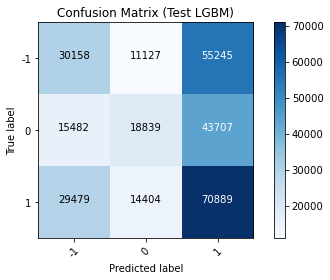

In [239]:
import seaborn as sns

cm = confusion_matrix(y_test, preds_test)
plot_confusion_matrix(cm, [-1, 0, 1])
plt.title("Confusion Matrix (Test LGBM)")

# Random Forest

In [240]:
train_preds_RF = direction_model_RF.predict(X_train[x_vals])

In [241]:
preds_test_RF = direction_model_RF.predict(X_test[x_vals])

Confusion matrix, without normalization
[[344280      2      1]
 [     4 277461      1]
 [     2      1 444863]]


Text(0.5, 1.0, 'Confusion Matrix (Train RF)')

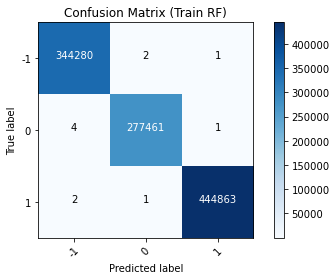

In [242]:
import seaborn as sns

cm = confusion_matrix(y_train, train_preds_RF)
plot_confusion_matrix(cm, [-1, 0, 1])
plt.title("Confusion Matrix (Train RF)")

In [243]:
from sklearn.metrics import classification_report
print("Classification Report for Train")
print(classification_report(y_train, train_preds_RF))

Classification Report for Train
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00    344283
         0.0       1.00      1.00      1.00    277466
         1.0       1.00      1.00      1.00    444866

    accuracy                           1.00   1066615
   macro avg       1.00      1.00      1.00   1066615
weighted avg       1.00      1.00      1.00   1066615



In [244]:
print("Classification Report for Test")
print(classification_report(y_test, preds_test_RF))

Classification Report for Test
              precision    recall  f1-score   support

        -1.0       0.38      0.36      0.37     96530
         0.0       0.40      0.21      0.27     78028
         1.0       0.42      0.57      0.48    114772

    accuracy                           0.40    289330
   macro avg       0.40      0.38      0.37    289330
weighted avg       0.40      0.40      0.39    289330



Confusion matrix, without normalization
[[34769 11186 50575]
 [20594 16058 41376]
 [36455 12738 65579]]


Text(0.5, 1.0, 'Confusion Matrix (Test RF)')

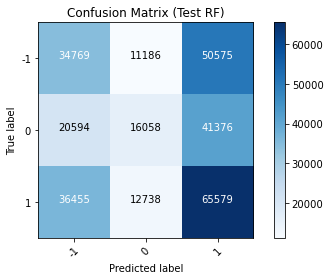

In [245]:
import seaborn as sns

cm = confusion_matrix(y_test, preds_test_RF)
plot_confusion_matrix(cm, [-1, 0, 1])
plt.title("Confusion Matrix (Test RF)")

# Save all Predictions

In [250]:
X_train_with_preds = X_train.merge(final_prediction_dataframe_monthly, left_index=True, right_index=True, how="left")

In [256]:
X_train_with_preds[["LGBMClassifier", "AdaBoostClassifier", "GradientBoostingClassifier", "RandomForestClassifier", "ExtraTreesClassifier"]] = X_train_with_preds[["LGBMClassifier", "AdaBoostClassifier", "GradientBoostingClassifier", "RandomForestClassifier", "ExtraTreesClassifier"]].fillna(0)

In [257]:
X_test_with_preds = X_test.copy()
X_test_with_preds["LGBMClassifier"] = preds_test
X_test_with_preds["RandomForestClassifier"] = preds_test_RF

In [259]:
full_period_out_of_fold_preds = pd.concat([X_train_with_preds, X_test_with_preds])

In [265]:
full_period_out_of_fold_preds.drop(columns="Unnamed: 0")[["date", "ticker", "LGBMClassifier", "AdaBoostClassifier", "GradientBoostingClassifier", "RandomForestClassifier", "ExtraTreesClassifier"]].to_csv("../results/full_period_out_of_fold_preds.csv", index=False)

In [276]:
full_dates = pd.DataFrame(pd.bdate_range(START_DATE, END_DATE)).rename(columns={0:"date"})

In [280]:
mask = read_from_s3("historical_sp500_mask_2010_onwards.csv").rename(columns={"Unnamed: 0":"date"})
mask.date = pd.to_datetime(mask.date)
mask.set_index("date", inplace=True)
mask = full_dates.merge(mask, on="date", how="left").set_index("date")
mask = mask[returns_df.columns[returns_df.columns.isin(mask.columns)]]

In [ ]:
full_period_out_of_fold_preds = full_period_out_of_fold_preds.drop_duplicates(subset=["date", "ticker"])

In [285]:
model_returns_full = dict()
for model_name in ["LGBMClassifier"]:
     position_long_only_signal = full_dates.merge(full_period_out_of_fold_preds.pivot(index="date", columns="ticker", values=model_name).reset_index(), on="date", how="left")
     position_long_only_signal = position_long_only_signal.ffill(limit=21).set_index("date").clip(lower=0).fillna(0)
     position_long_only_signal = position_long_only_signal[mask.columns[mask.columns.isin(position_long_only_signal.columns)]]
     position_long_only_signal = position_long_only_signal * mask
     position_long_only_weight = position_long_only_signal.div(position_long_only_signal.sum(axis=1), axis=0).fillna(0)
     common_columns = position_long_only_weight.columns[position_long_only_weight.columns.isin(returns_df.columns)]
     position_long_only_weight = position_long_only_weight[common_columns]
     port_returns = returns_df.copy().reset_index().rename(columns={"Date":"date"})
     port_returns = full_dates.merge(port_returns, on="date", how="left").set_index("date").fillna(0)[position_long_only_weight.columns]
     portfolio_long_only = (port_returns[position_long_only_weight.columns] * position_long_only_weight.fillna(0))

     model_returns_full[model_name] = portfolio_long_only.sum(axis=1)

# Data for Dashboard

In [421]:
all_preds_LGBM = direction_model.predict(training_test_df_monthly[x_vals])

In [422]:
training_test_df_monthly["LGBMClassifier"] = all_preds_LGBM

In [423]:
LGBM_Portfolio_Holdings = full_dates.merge(training_test_df_monthly.pivot(index="date", columns="ticker", values="LGBMClassifier").reset_index(), on="date", how="left")
LGBM_Portfolio_Holdings = LGBM_Portfolio_Holdings.ffill(limit=21).set_index("date").clip(lower=0).fillna(0)
LGBM_Portfolio_Holdings = LGBM_Portfolio_Holdings[mask.columns[mask.columns.isin(LGBM_Portfolio_Holdings.columns)]]
LGBM_Portfolio_Holdings = LGBM_Portfolio_Holdings * mask

In [425]:
final_portfolio_holdings = np.sign(LGBM_Portfolio_Holdings)

In [426]:
LGBM_Portfolio_Weight = LGBM_Portfolio_Holdings.div(LGBM_Portfolio_Holdings.sum(axis=1), axis=0).fillna(0)

In [400]:
port_returns = returns_df.copy().reset_index().rename(columns={"Date":"date"})
port_returns = full_dates.merge(port_returns, on="date", how="left").set_index("date").fillna(0)[final_portfolio_holdings.columns]

In [435]:
final_portfolio_weights = LGBM_Portfolio_Weight
final_portfolio_weights = final_portfolio_weights.clip(upper=0.1)

In [436]:
individual_stock_returns = (port_returns[final_portfolio_holdings.columns] * final_portfolio_weights.fillna(0))
individual_stock_returns = np.log(individual_stock_returns + 1).cumsum()

In [439]:
write_to_s3(final_portfolio_holdings.reset_index(), "dashboard_data/final_portfolio_holdings.csv")
write_to_s3(final_portfolio_weights.reset_index(), "dashboard_data/final_portfolio_weights.csv")
write_to_s3(individual_stock_returns.reset_index(), "dashboard_data/individual_stock_returns.csv")

In [464]:
price_dataframe = yf.download("^GSPC")
price_dataframe = full_dates.merge(price_dataframe.reset_index().rename(columns={"Date":"date"})).set_index("date")

[*********************100%***********************]  1 of 1 completed


In [453]:
final_model_returns = pd.DataFrame(pd.DataFrame(model_returns_full).mean(axis=1))
final_model_returns.columns = ["Returns"]
final_model_returns["Cumulative Returns"] = (final_model_returns.Returns + 1).cumprod()
final_model_returns["Cumulative Log Returns"] = np.log(final_model_returns.Returns + 1).cumsum()

In [455]:
write_to_s3(final_model_returns, "results/final_model_returns.csv")
write_to_s3(final_model_returns, "dashboard_data/final_model_returns.csv")